# Watches Image Classification

**Team:4**
* Harsh Deokuliar
* Sameer Mahajan


**Course:** DAAN 570– Deep Learning (Spring I, 2022)

#### importing necessary libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE
import seaborn as sns
from random import randint
from tensorflow.keras.preprocessing import image
from contextlib import suppress
import tensorflow as tf
from tensorflow.keras import Input, Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPooling2D,AveragePooling2D, Conv2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121, DenseNet201, ResNet50, VGG19, InceptionV3, EfficientNetB7
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.metrics import AUC
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
from keras.utils import np_utils


# path to images
path = 'C:/Users/parvb/Downloads/output (1)/output/'

# watch categories
categories = ['Breitling', 'Casio','Gucci','Rolex','Seiko']

Preprocessing has been done in another notebook called watch_scraper. We will proceed with creating our ImageDataGenerator.

Preprocessing steps included:

1) Removing images which were not watches( items like watch spareparts, belts etc). This was done manually.

2) Reshaping images to 180,180 dimension for image classification using DNNs

#### Image Augmentation


In [2]:
img_height = 180
img_width = 180
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_1 = ImageDataGenerator(rotation_range=40,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       vertical_flip=False,
                                       rescale=1/255.0,
                                       validation_split=0.2)
testgen_1 = ImageDataGenerator(rescale=1/255.0) 



train_data_gen = datagen_1.flow_from_directory('C:/Users/parvb/Downloads/Sameer_Harsh/data/output/train',
                                                        target_size=(img_height, img_width),
                                                        batch_size=32,
                                                        shuffle=True,seed=42,
                                                        class_mode='categorical',subset='training') 
val_data_gen = datagen_1.flow_from_directory('C:/Users/parvb/Downloads/Sameer_Harsh/data/output/val',
                                                        target_size=(img_height, img_width),
                                                        batch_size=32,
                                                        shuffle=True,seed=42,
                                                        class_mode='categorical',subset='validation') 
scale_test_gen = datagen_1.flow_from_directory('C:/Users/parvb/Downloads/Sameer_Harsh/data/output/test',#directory
                                                        target_size=(180,180),#All images will be resized to 180x180,
                                                        batch_size=1400,
                                                        shuffle=True,
                                                        class_mode='categorical') 

Found 8469 images belonging to 5 classes.
Found 261 images belonging to 5 classes.
Found 1326 images belonging to 5 classes.


### Methodology

We will be training 3 deep learning models - DenseNet201 , InceptionV3 and our own custom model.

 * DenseNet201
    * DenseNet-201 is a convolutional neural network that is 201 layers deep. It has around 18 million parametres.
 * InceptionV3
    * Inception v3 is a convolutional neural network for assisting in image analysis and object detection, and got its start as a module for Googlenet. Its has around 21 million parameters.
 
 * Custom model
     * Our custom model consists of 5 Conv2D layers, with (3,3) sized windows, followed by a flatten and dense layers and then the output layer with an softmax activation. All hidden layers have relu activation functions.
     
All models were run on kaggle using the free gpu.

## Classification of Watch models

### Custom CNN model

In [75]:
custom_model = Sequential()
custom_model.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=(180,180,3),activation='relu'))
custom_model.add(AveragePooling2D(2))
# custom_model.add(Dropout(0.4))

custom_model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
custom_model.add(AveragePooling2D(2))
# custom_model.add(Dropout(0.4))



custom_model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
custom_model.add(AveragePooling2D(2))
# custom_model.add(Dropout(0.4))


custom_model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
custom_model.add(AveragePooling2D(2))
custom_model.add(Dropout(0.4))


custom_model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
custom_model.add(AveragePooling2D(2))
custom_model.add(Dropout(0.4))
custom_model.add(Flatten())

custom_model.add(Dense(32, activation='relu'))
custom_model.add(BatchNormalization())
custom_model.add(Dropout(0.4))

custom_model.add(Dense(5,activation='softmax'))


class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True      
my_callback = MyCallback()
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)
es_callback = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True)

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]

CALLBACKS = [my_callback, rop_callback, es_callback]
    
custom_model.compile(optimizer='adam',
                              loss='categorical_crossentropy',
                              metrics=METRICS)

custom_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 178, 178, 64)      1792      
                                                                 
 average_pooling2d_9 (Averag  (None, 89, 89, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_11 (Conv2D)          (None, 87, 87, 128)       73856     
                                                                 
 average_pooling2d_10 (Avera  (None, 43, 43, 128)      0         
 gePooling2D)                                                    
                                                                 
 conv2d_12 (Conv2D)          (None, 41, 41, 256)       295168    
                                                                 
 average_pooling2d_11 (Avera  (None, 20, 20, 256)     

Below are some callbacks that were used during training.

1) Stopping training if accuracy reached 99%.

2) Early stopping which monitors the validation accuracy with a patience of 10 epochs.  It also restores the best weights based on validation accuracy.

In [76]:
EPOCHS = 100
history = custom_model.fit(train_data_gen, validation_data=val_data_gen,epochs=EPOCHS,callbacks=CALLBACKS)

Epoch 1/100
265/265 [==============================] - 50s 181ms/step - loss: 1.5902 - acc: 0.2764 - auc: 0.6025 - val_loss: 1.5679 - val_acc: 0.2989 - val_auc: 0.6515 - lr: 0.0010
Epoch 2/100
265/265 [==============================] - 45s 170ms/step - loss: 1.4759 - acc: 0.3390 - auc: 0.6792 - val_loss: 1.4899 - val_acc: 0.3142 - val_auc: 0.6518 - lr: 0.0010
Epoch 3/100
265/265 [==============================] - 44s 165ms/step - loss: 1.3996 - acc: 0.3873 - auc: 0.7235 - val_loss: 1.3788 - val_acc: 0.4330 - val_auc: 0.7494 - lr: 0.0010
Epoch 4/100
265/265 [==============================] - 44s 166ms/step - loss: 1.3498 - acc: 0.4220 - auc: 0.7494 - val_loss: 1.1807 - val_acc: 0.5019 - val_auc: 0.8218 - lr: 0.0010
Epoch 5/100
265/265 [==============================] - 46s 173ms/step - loss: 1.2921 - acc: 0.4651 - auc: 0.7763 - val_loss: 1.1118 - val_acc: 0.5479 - val_auc: 0.8432 - lr: 0.0010
Epoch 6/100
265/265 [==============================] - 46s 173ms/step - loss: 1.2485 - acc: 0.4

**Custom CNN model classification plots**

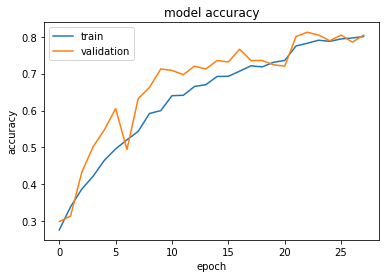

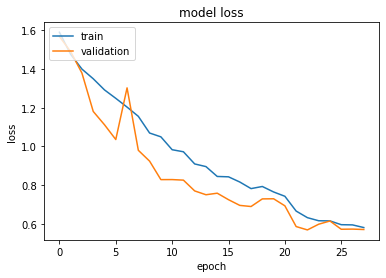

In [77]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [79]:
# save model
custom_model.save('custom_model_watches.h5')


In [3]:
with tf.device('/CPU:0'):
    custom_model = tf.keras.models.load_model('C:/Users/parvb/Downloads/Sameer_Harsh/models/watch_classification/custom_model_watches.h5')
    custom_model.evaluate(scale_test_gen)

1/1 [==============================] - 35s 35s/step - loss: 0.5935 - acc: 0.7828 - auc: 0.9564


In [4]:
test_data,test_labels = scale_test_gen.next()

**Plotting classification report and confusion matrix for custom CNN model**

              precision    recall  f1-score   support

   Breitling       0.80      0.75      0.77       263
       Casio       0.81      0.84      0.82       265
       Gucci       0.76      0.84      0.80       263
       Rolex       0.85      0.85      0.85       271
       Seiko       0.73      0.69      0.71       264

   micro avg       0.79      0.79      0.79      1326
   macro avg       0.79      0.79      0.79      1326
weighted avg       0.79      0.79      0.79      1326
 samples avg       0.79      0.79      0.79      1326



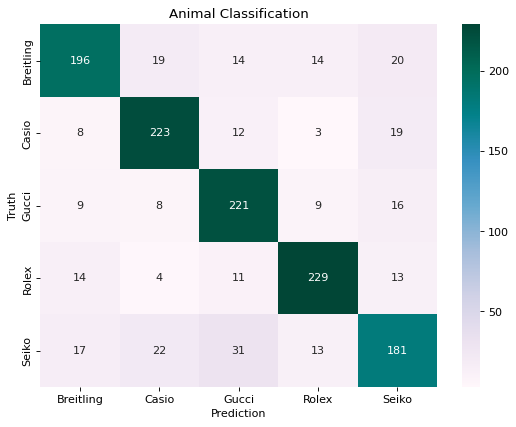

In [5]:
pred_lab = custom_model.predict(test_data)

# Classification report block
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_lab:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_lab, target_names=categories))

# Confussion Matrix block
pred_ls = np.argmax(pred_lab, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='PuBuGn', annot=True, fmt='d', xticklabels= categories,
                yticklabels=categories)

plt.title('Animal Classification')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

Our custom model performs well on clsses such as Rolex, Gucci, Casio. The accuracy we are getting with our Custom CNN is about 78.28%.

Let's see if our transfer learning models can help us improve the accuracy 

### InceptionV3 Transfer Learning

In [3]:
INV3 = InceptionV3(input_shape=(180,180, 3), include_top=False, weights="imagenet")

for layer in INV3.layers:
    layer.trainable=False
    
INV3_model=Sequential()
INV3_model.add(INV3)
INV3_model.add(Flatten())
INV3_model.add(Dense(256, activation='relu'))
INV3_model.add(Dense(5,activation='softmax'))

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True      
my_callback = MyCallback()
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)
es_callback = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True)

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]

CALLBACKS = [my_callback, rop_callback, es_callback]
    
INV3_model.compile(optimizer='adam',
                              loss='categorical_crossentropy',
                              metrics=METRICS)

In [4]:
INV3_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 30,192,933
Trainable params: 8,390,149
Non-trainable params: 21,802,784
_________________________________________________________________


In [5]:
INV3_model.summary()
EPOCHS = 100
history = INV3_model.fit(train_data_gen, validation_data=val_data_gen, 
                                  epochs=EPOCHS)

Epoch 1/100
277/277 [==============================] - 62s 187ms/step - loss: 2.9088 - acc: 0.6054 - auc: 0.8339 - val_loss: 0.9529 - val_acc: 0.6618 - val_auc: 0.8981
Epoch 2/100
277/277 [==============================] - 45s 164ms/step - loss: 0.8275 - acc: 0.7165 - auc: 0.9170 - val_loss: 0.9249 - val_acc: 0.7018 - val_auc: 0.8991
Epoch 3/100
277/277 [==============================] - 45s 162ms/step - loss: 0.6892 - acc: 0.7582 - auc: 0.9405 - val_loss: 0.8581 - val_acc: 0.7491 - val_auc: 0.9147
Epoch 4/100
277/277 [==============================] - 49s 176ms/step - loss: 0.6434 - acc: 0.7778 - auc: 0.9474 - val_loss: 0.8188 - val_acc: 0.7018 - val_auc: 0.9203
Epoch 5/100
277/277 [==============================] - 46s 164ms/step - loss: 0.5833 - acc: 0.7950 - auc: 0.9568 - val_loss: 0.8099 - val_acc: 0.7236 - val_auc: 0.9296
Epoch 6/100
277/277 [==============================] - 45s 163ms/step - loss: 0.5396 - acc: 0.8146 - auc: 0.9622 - val_loss: 0.8250 - val_acc: 0.7200 - val_auc:

277/277 [==============================] - 46s 165ms/step - loss: 0.2323 - acc: 0.9206 - auc: 0.9924 - val_loss: 1.0160 - val_acc: 0.7418 - val_auc: 0.9199
Epoch 98/100
277/277 [==============================] - 46s 166ms/step - loss: 0.2336 - acc: 0.9193 - auc: 0.9921 - val_loss: 0.9866 - val_acc: 0.7564 - val_auc: 0.9227
Epoch 99/100
277/277 [==============================] - 46s 167ms/step - loss: 0.2341 - acc: 0.9174 - auc: 0.9918 - val_loss: 0.8193 - val_acc: 0.7782 - val_auc: 0.9401
Epoch 100/100
277/277 [==============================] - 46s 166ms/step - loss: 0.2366 - acc: 0.9145 - auc: 0.9920 - val_loss: 0.8276 - val_acc: 0.7891 - val_auc: 0.9394


**InceptionV3 model classification plots**

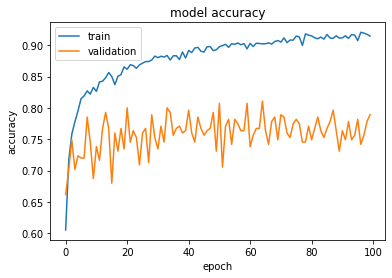

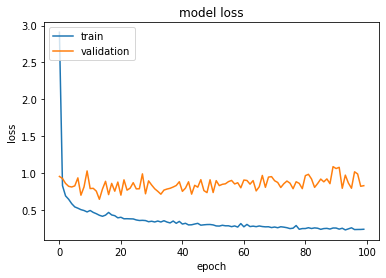

In [6]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [8]:
#save model
INV3_model.save('Inception_More_Data.h5')

In [6]:
with tf.device('/CPU:0'):
    INV3_model = tf.keras.models.load_model('C:/Users/parvb/Downloads/Sameer_Harsh/models/watch_classification/InceptionV3_model_watches_classification.h5')
    INV3_model.evaluate(scale_test_gen)

1/1 [==============================] - 20s 20s/step - loss: 0.3765 - acc: 0.8891 - auc: 0.9792


**Plotting classification report and confusion matrix for inceptionv3**

              precision    recall  f1-score   support

   Breitling       0.85      0.92      0.88       263
       Casio       0.88      0.96      0.92       265
       Gucci       0.88      0.89      0.88       263
       Rolex       0.94      0.83      0.88       271
       Seiko       0.85      0.80      0.83       264

   micro avg       0.88      0.88      0.88      1326
   macro avg       0.88      0.88      0.88      1326
weighted avg       0.88      0.88      0.88      1326
 samples avg       0.88      0.88      0.88      1326



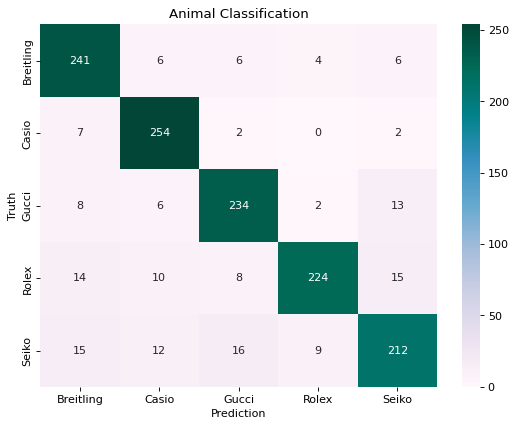

In [7]:
#load model

pred_lab = INV3_model.predict(test_data)

# Classification report block
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_lab:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_lab, target_names=categories))

# Confussion Matrix block
pred_ls = np.argmax(pred_lab, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='PuBuGn', annot=True, fmt='d', xticklabels= categories,
                yticklabels=categories)

plt.title('Animal Classification')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

Our custom model performs very well. The accuracy we are getting with our InceptionV3 Transfer learning model is about 88.91%. The accuracy significantly improved from our Custom model, which helps us notice the benefits of transfer learning 

Let's see if our DenseNet201 model can help us improve the accuracy 

### DenseNet201 Transfer Learning

In [55]:
DNET201 = DenseNet201(input_shape=(180,180, 3), include_top=False, weights="imagenet")

for layer in DNET201.layers:
    layer.trainable=False
    
DNET201_model=Sequential()
DNET201_model.add(DNET201)
DNET201_model.add(Flatten())
DNET201_model.add(Dense(1024, activation='relu'))
DNET201_model.add(Dense(5,activation='softmax'))

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True      
my_callback = MyCallback()
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)
es_callback = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True)

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]

CALLBACKS = [my_callback, rop_callback, es_callback]
    
DNET201_model.compile(optimizer='adam',
                              loss='categorical_crossentropy',
                              metrics=METRICS)

In [56]:
DNET201_model.summary()
EPOCHS = 100
history = DNET201_model.fit(train_data_gen, validation_data=val_data_gen, 
                                  epochs=EPOCHS)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 5, 5, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 48000)             0         
                                                                 
 dense_16 (Dense)            (None, 1024)              49153024  
                                                                 
 dense_17 (Dense)            (None, 5)                 5125      
                                                                 
Total params: 67,480,133
Trainable params: 49,158,149
Non-trainable params: 18,321,984
_________________________________________________________________
Epoch 1/100
265/265 [==============================] - 84s 269ms/step - loss: 3.6340 - acc: 0.7082 - auc: 0.8865 - val_loss: 0.6118 - val_acc: 0.7931 - val_auc: 0.95

Epoch 44/100
265/265 [==============================] - 45s 169ms/step - loss: 0.1033 - acc: 0.9650 - auc: 0.9974 - val_loss: 0.8584 - val_acc: 0.8352 - val_auc: 0.9520
Epoch 45/100
265/265 [==============================] - 45s 171ms/step - loss: 0.0972 - acc: 0.9662 - auc: 0.9977 - val_loss: 0.7339 - val_acc: 0.8621 - val_auc: 0.9645
Epoch 46/100
265/265 [==============================] - 45s 168ms/step - loss: 0.0983 - acc: 0.9675 - auc: 0.9976 - val_loss: 0.9556 - val_acc: 0.8506 - val_auc: 0.9449
Epoch 47/100
265/265 [==============================] - 46s 172ms/step - loss: 0.0982 - acc: 0.9687 - auc: 0.9972 - val_loss: 0.8074 - val_acc: 0.8621 - val_auc: 0.9543
Epoch 48/100
265/265 [==============================] - 45s 169ms/step - loss: 0.0991 - acc: 0.9660 - auc: 0.9978 - val_loss: 0.7877 - val_acc: 0.8582 - val_auc: 0.9537
Epoch 49/100
265/265 [==============================] - 46s 172ms/step - loss: 0.0888 - acc: 0.9713 - auc: 0.9979 - val_loss: 0.7483 - val_acc: 0.8467 - va

**DenseNet201 model classification plots**

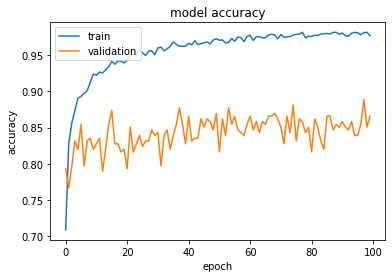

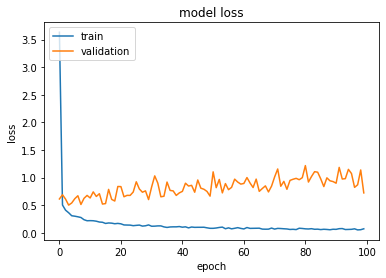

In [57]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [8]:
with tf.device('/CPU:0'):
    DNET_model = tf.keras.models.load_model('C:/Users/parvb/Downloads/Sameer_Harsh/models/watch_classification/DenseNet201_model_watches_classification.h5')
    DNET_model.evaluate(scale_test_gen)

1/1 [==============================] - 65s 65s/step - loss: 0.6459 - acc: 0.8861 - auc: 0.9679


**Plotting classification report and confusion matrix for DenseNet201**

              precision    recall  f1-score   support

   Breitling       0.87      0.88      0.88       263
       Casio       0.93      0.91      0.92       265
       Gucci       0.87      0.87      0.87       263
       Rolex       0.94      0.91      0.92       271
       Seiko       0.79      0.83      0.81       264

   micro avg       0.88      0.88      0.88      1326
   macro avg       0.88      0.88      0.88      1326
weighted avg       0.88      0.88      0.88      1326
 samples avg       0.88      0.88      0.88      1326



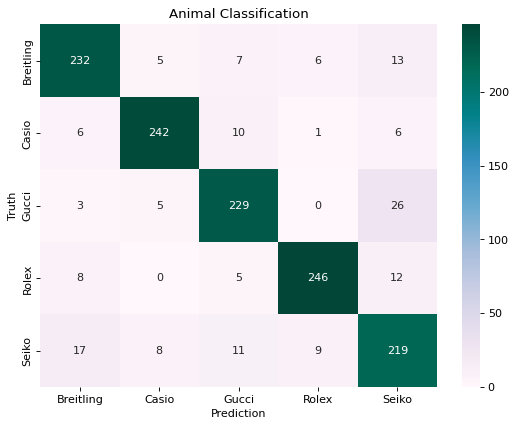

In [9]:
#load model

pred_lab = DNET_model.predict(test_data)

# Classification report block
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_lab:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_lab, target_names=categories))

# Confussion Matrix block
pred_ls = np.argmax(pred_lab, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='PuBuGn', annot=True, fmt='d', xticklabels= categories,
                yticklabels=categories)

plt.title('Animal Classification')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

Our densenet201 model performs very well. The accuracy we are getting with our DenseNet201 Transfer learning model is about 88.61% which is almost equivalent to the inceptionV3 result. 

**Issues and Improvements**

1) Higher quality images with brand logos will improve the model

2) Using more complex models can improve the model but it uses a lot more computation power which is difficult to obtain.